<a href="https://colab.research.google.com/github/cpvivek/Facial-Emotion-Recognition/blob/main/Capstone_DL%26MLE_Facial_Emotion_Recognition_Vivek_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Emotion Detection
In this project, we are aiming to develop a CNN netwrok to detect 7 different human emotions in real time over a live web-cam feed. We'll also be deploying a web app to run this model.

Importing necessary libraries including tensorflow, keras, sklearn and opencv

In [1]:
# import necessary files
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten

Importing dataset sourced from kaggle

In [3]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


reading the csv file.

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Alma Better Pro/Alma Better Pro Program/Module 4: Machine Learning/Data Sets/icml_face_data.csv')
# for i in range(len(df[' pixels'])):
#   df[' pixels'][i] = np.fromstring(df[' pixels'][i],sep=' ',dtype='float32')
#   df[' pixels'][i] = np.asarray(df[' pixels'][i]).reshape(48,48,1)
# train_data = df[df[' Usage']=='Training']
# val_data = df[df[' Usage']=='PublicTest']
# test_data = df[df[' Usage']=='PrivateTest']

Let's look into our dataset

In [ ]:
df.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

So the dataset is not all that complicated.

We've got 'emotion' field indicating different emotions.

I believe since this is a dataset used in kaggle competitions, they've went ahead and done the training, validation and test segregation, labeled by 'Usage' column

And finally in the 'pixels' field, we have the pixelated form of the image, flattened into an 1 dimension array. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


The pixel field is stored as a string at the moment. We'll have to convert that into a 48x48x1 array with float values.

In [5]:
#using lambda function to achieve this conversion
df[' pixels']=df[' pixels'].apply(lambda x: np.fromstring(x, sep=' ',dtype='float32')) #converting string to float separated by ' ' 
df[' pixels']=df[' pixels'].apply(lambda x:np.asarray(x.reshape(48,48,1))) #reshaping to 48x48x1

Let's look into emotions field.

In [ ]:
df['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

The dataset contains 7 different emotions labeled using number from 0 to 6.

Let's segregate our training, validation and test sets right away. 

Public Test would be put into validation and Private test into test set. 

In [ ]:
df[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [6]:
#defininng train, val and test data.
training_data=df[df[' Usage']=='Training']
validation_data=df[df[' Usage']=='PublicTest']
testing_data=df[df[' Usage']=='PrivateTest']

In [ ]:
training_data['emotion'].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

We can see that there is considerable amount of imbalance in the dataset wrt to emotions in training dataset. This will create bias in the model and result in misclassifying. 

We can treat this issue by data augmentation.

Using keras for data augmentation.

x_train formation


In [7]:
x_train=[]
for i in range(len(training_data[' pixels'])):
  x_train.append(training_data[' pixels'][i])
x_train=np.asarray(x_train) #since we need arrays as input to CNN 
x_train=x_train.reshape(len(x_train),48,48,1)
y_train=np.array(training_data['emotion'])
y_train=y_train.astype(int)
y_train=np_utils.to_categorical(y_train,7)
# shape of training data
x_train.shape, y_train.shape

((28709, 48, 48, 1), (28709, 7))

x_val

In [8]:
x_val = []
for i in validation_data[' pixels']:
  x_val.append(i)
x_val=np.asarray(x_val)
x_val= x_val.reshape(len(x_val),48,48,1)
y_val=np.array(validation_data['emotion'])
y_val=y_val.astype(int)
y_val=np_utils.to_categorical(y_val,7)



x_val.shape,y_val.shape

((3589, 48, 48, 1), (3589, 7))

Preprocessing x_test using keras

In [9]:
x_test = []

for i in testing_data[' pixels']:
  x_test.append(i)
x_test=np.array(x_test)
x_test=x_test.reshape(len(x_test),48,48,1)
y_test=np.array(testing_data['emotion'])
y_test=y_test.astype(int)
y_test=np_utils.to_categorical(y_test,7)
# code here

# then check shape
x_test.shape,y_test.shape

((3589, 48, 48, 1), (3589, 7))

Data Augmentation Process.

We can observe that there is a imbalance in labels in train, val and test sets. This will result in bias in the model twoards certain emotions.

We'll be able to sort this issue adding augmented images to data to deal with imbalance.

In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen= ImageDataGenerator(
    rescale=1./255, #rescaling
    rotation_range=10,#rotating the image
    horizontal_flip=True,#flipping the image horizontally
    width_shift_range=0.1,
    height_shift_range=0.1, #shift in width and height
    fill_mode='nearest'
)
testgen= ImageDataGenerator(rescale=1./255)

In [11]:
datagen.fit(x_train)

In [12]:
train_flow=datagen.flow(x_train,y_train,batch_size=64)
test_flow=testgen.flow(x_test,y_test,batch_size=64)

Building models usign keras layers and keras sequential model

In [13]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix


#Model 1

In [51]:
model_fer_1 = Sequential()

model_fer_1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model_fer_1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_1.add(Dropout(0.5))

model_fer_1.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_1.add(Dropout(0.5))

model_fer_1.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_1.add(Dropout(0.5))

model_fer_1.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_1.add(BatchNormalization())
model_fer_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_1.add(Dropout(0.5))

model_fer_1.add(Flatten())

model_fer_1.add(Dense(512, activation='relu'))
model_fer_1.add(Dropout(0.4))
model_fer_1.add(Dense(256, activation='relu'))
model_fer_1.add(Dropout(0.4))
model_fer_1.add(Dense(128, activation='relu'))
model_fer_1.add(Dropout(0.5))
model_fer_1.add(Dense(7, activation='softmax'))
model_fer_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_6 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

In [53]:
model=model_fer_1
opt=tf.keras.optimizers.Adam(learning_rate=0.0001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

In [55]:
num_epochs = 100
history = model.fit(train_flow, 
                    steps_per_epoch=len(x_train) / 64, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=test_flow)


Epoch 1/100
448/448 [==============================] - 23s 51ms/step - loss: 2.1249 - accuracy: 0.1864 - val_loss: 1.8364 - val_accuracy: 0.2449
Epoch 2/100
448/448 [==============================] - 21s 46ms/step - loss: 1.9028 - accuracy: 0.2012 - val_loss: 1.8227 - val_accuracy: 0.2441
Epoch 3/100
448/448 [==============================] - 21s 46ms/step - loss: 1.8622 - accuracy: 0.2146 - val_loss: 1.8120 - val_accuracy: 0.2444
Epoch 4/100
448/448 [==============================] - 22s 48ms/step - loss: 1.8467 - accuracy: 0.2223 - val_loss: 1.8247 - val_accuracy: 0.2449
Epoch 5/100
448/448 [==============================] - 21s 47ms/step - loss: 1.8363 - accuracy: 0.2275 - val_loss: 1.8059 - val_accuracy: 0.2449
Epoch 6/100
448/448 [==============================] - 21s 46ms/step - loss: 1.8313 - accuracy: 0.2349 - val_loss: 1.8092 - val_accuracy: 0.2449
Epoch 7/100
448/448 [==============================] - 21s 46ms/step - loss: 1.8248 - accuracy: 0.2399 - val_loss: 1.8106 - val_ac

In [56]:
model_json = model_fer_1.to_json()
with open("model_fer_1.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_fer_1.h5")
print("Saved model to disk")

Saved model to disk


In [57]:
#total loss and accuracy in training the dataset on test set
score = model_fer_1.evaluate(x_test/255., y_test, verbose=1) 
print("Test Loss: ", (score[0]))
print("Test Accuracy: ",  score[1]*100)

113/113 [==============================] - 3s 11ms/step - loss: 0.9044 - accuracy: 0.6668
Test Loss:  0.9043591618537903
Test Accuracy:  66.67595505714417


In [58]:
from keras.preprocessing import image
def pred_emotion(img_path):
  emotion_dict = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad',5: 'suprise', 6: 'neutral'}
  img = image.load_img(img_path, grayscale=True, target_size=(48,48))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  prediction = np.argmax(model_fer_1.predict(x))
  print('The predicted emotion is : ' + emotion_dict[prediction])
  my_image = image.load_img(img_path)
  plt.imshow(my_image)
  result = plt.show()
  return result

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The predicted emotion is : anger


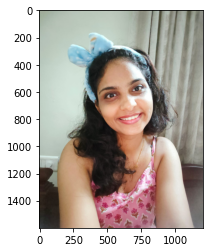

In [62]:
pred_emotion("/content/drive/MyDrive/Cloudy ML/opencv/happy aishu2.jfif")

#Model 2

In [14]:
# def FER_Model(input_shape=(48,48,1)):
#     # first input model
#     visible = Input(shape=input_shape, name='input')

#     #the 1-st block
#     conv1_1 = Conv2D(32, kernel_size=3, strides=(1,1),activation='relu', name = 'conv1_1')(visible)
#     pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_1)
#     conv1_1 = BatchNormalization()(pool1_1)

#     #the 2-nd block
#     conv2_1 = Conv2D(64, kernel_size=3, strides=(1,1),activation='relu',name = 'conv2_1')(conv1_1)
#     pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_1)
#     conv2_1 = BatchNormalization()(pool2_1)

#     #the 3-rd block
#     conv3_1 = Conv2D(128, kernel_size=3,strides=(1,1), activation='relu', name = 'conv3_1')(pool2_1)
#     pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_1)
#     conv3_1 = BatchNormalization()(pool3_1)

#     #Flatten and output
#     flatten = Flatten(name = 'flatten')(conv3_1)
#     drop1 = Dense(480, activation='relu', name = 'drop1')(flatten)
#     drop2 = Dense(240, activation='relu', name = 'drop2')(drop1)
#     ouput = Dense(7, activation='softmax', name = 'output')(drop2)

#     # create model 
#     model = Model(inputs =visible, outputs = ouput)
    
#     # summary layers
#     print(model.summary())
    
#     return model

In [31]:
model=FER_Model()
opt=tf.keras.optimizers.Adam(lr=0.0001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 46, 46, 32)        320       
                                                                 
 pool1_1 (MaxPooling2D)      (None, 23, 23, 32)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 23, 23, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2_1 (Conv2D)            (None, 21, 21, 64)        18496     
                                                                 
 pool2_1 (MaxPooling2D)      (None, 10, 10, 64)        0         
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
num_epochs = 200
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(x_train) / 64, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=test_flow)


Epoch 1/200
  1/448 [..............................] - ETA: 28s - loss: 1.1463 - accuracy: 0.5781

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


448/448 [==============================] - 12s 26ms/step - loss: 1.2088 - accuracy: 0.5428 - val_loss: 1.1857 - val_accuracy: 0.5439
Epoch 2/200
448/448 [==============================] - 12s 26ms/step - loss: 1.1862 - accuracy: 0.5499 - val_loss: 1.1746 - val_accuracy: 0.5397
Epoch 3/200
448/448 [==============================] - 12s 26ms/step - loss: 1.1676 - accuracy: 0.5562 - val_loss: 1.1707 - val_accuracy: 0.5639
Epoch 4/200
448/448 [==============================] - 12s 26ms/step - loss: 1.1448 - accuracy: 0.5639 - val_loss: 1.1638 - val_accuracy: 0.5573
Epoch 5/200
448/448 [==============================] - 12s 26ms/step - loss: 1.1307 - accuracy: 0.5731 - val_loss: 1.1461 - val_accuracy: 0.5737
Epoch 6/200
448/448 [==============================] - 12s 26ms/step - loss: 1.1108 - accuracy: 0.5812 - val_loss: 1.1486 - val_accuracy: 0.5706
Epoch 7/200
448/448 [==============================] - 12s 26ms/step - loss: 1.1001 - accuracy: 0.5852 - val_loss: 1.1099 - val_accuracy: 0.57

In [18]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [36]:
from tensorflow.keras.models import model_from_json
model = model_from_json(open("/content/model.json", "r").read())
model.load_weights('model.h5')
opt=tf.keras.optimizers.Adam(lr=0.0001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [37]:
#total loss and accuracy in training the dataset on test set
score = model.evaluate(x_test/255., y_test, verbose=1) 
print("Test Loss: ", (score[0]))
print("Test Accuracy: ",  score[1]*100)

113/113 [==============================] - 1s 3ms/step - loss: 1.5443 - accuracy: 0.6475
Test Loss:  1.5442516803741455
Test Accuracy:  64.75341320037842


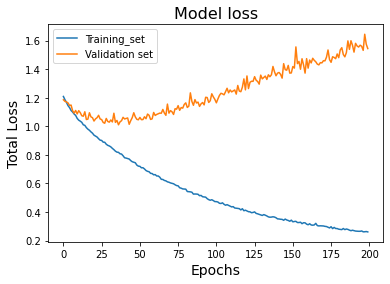

In [38]:
plt.plot(history.history['loss'], label="Training_set")
plt.plot(history.history['val_loss'], label="Validation set")
plt.title("Model loss", size=16)
plt.ylabel("Total Loss", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

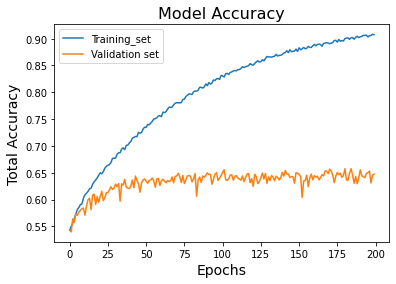

In [39]:
plt.plot(history.history['accuracy'], label="Training_set")
plt.plot(history.history['val_accuracy'], label="Validation set")
plt.title("Model Accuracy", size=16)
plt.ylabel("Total Accuracy", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

In [42]:
from keras.preprocessing import image
def pred_emotion(img_path):
  emotion_dict = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad',5: 'suprise', 6: 'neutral'}
  img = image.load_img(img_path, grayscale=True, target_size=(48,48))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  prediction = np.argmax(model.predict(x))
  print('The predicted emotion is : ' + emotion_dict[prediction])
  my_image = image.load_img(img_path)
  plt.imshow(my_image)
  result = plt.show()
  return result

The predicted emotion is : happy


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


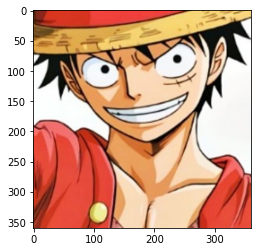

In [47]:
pred_emotion("/content/drive/MyDrive/Cloudy ML/opencv/image1.jpg")

#Transfer Learning